In [1]:
from datetime import datetime

import torch
import numpy as np


import util, tr_util
from my_gcn import GCN
from Dimploma.EnvironmentTree import EnvMinimalTreeTwoStep
from Dimploma.ppo_parallel_custom import Agent, test_random
from Dimploma.utils.graph_provider import GraphProvider

In [2]:
%load_ext autoreload
%autoreload 2

device:  cuda
Loading graph


C:\Users\Milos\AppData\Local\Temp\ipykernel_8804\1783966182.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph = torch.load(load_graph)


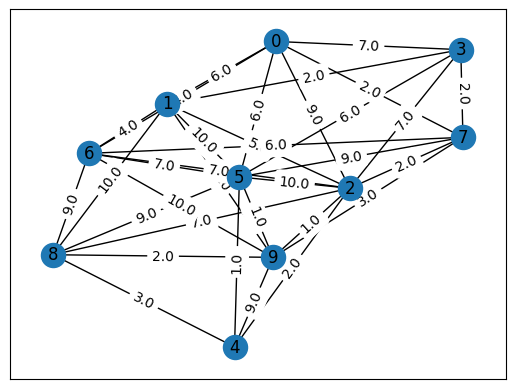

Name: n10_e33_g20_without
tensor([[0, 5, 5, 5, 8, 0, 7, 7, 1, 2, 1, 4, 5, 1, 5, 2, 6, 9, 3, 2, 2, 5, 3, 0,
         8, 4, 2, 3, 6, 6, 1, 2, 0],
        [5, 8, 2, 7, 4, 1, 9, 6, 3, 1, 5, 2, 3, 9, 4, 8, 9, 8, 7, 7, 6, 9, 2, 6,
         6, 9, 0, 0, 5, 1, 8, 9, 7]], device='cuda:0') 
 tensor([[ 0.6000,  0.0000,  6.0000],
        [ 0.9000,  0.0000,  9.0000],
        [ 1.0000,  0.0000, 10.0000],
        [ 0.9000,  0.0000,  9.0000],
        [ 0.3000,  0.0000,  3.0000],
        [ 0.6000,  0.0000,  6.0000],
        [ 0.3000,  0.0000,  3.0000],
        [ 0.6000,  0.0000,  6.0000],
        [ 0.2000,  0.0000,  2.0000],
        [ 0.5000,  0.0000,  5.0000],
        [ 1.0000,  0.0000, 10.0000],
        [ 0.2000,  0.0000,  2.0000],
        [ 0.6000,  0.0000,  6.0000],
        [ 0.8000,  0.0000,  8.0000],
        [ 0.1000,  0.0000,  1.0000],
        [ 0.7000,  0.0000,  7.0000],
        [ 1.0000,  0.0000, 10.0000],
        [ 0.2000,  0.0000,  2.0000],
        [ 0.2000,  0.0000,  2.0000],
        [ 0.200

In [18]:
node_amount = 10
max_edge_amount = torch.sum(torch.arange(node_amount)).item()
edge_amount = int(max_edge_amount*0.75)
iteration_amount = 1000
epoch_amount = 10
batch_size = 64
node_features = 2  # (index, {0,1} selected or not)
steps_amount = int((node_amount - 1)*2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device: ', device)
early_stop = True
position = False
remove_index = True
if position:
    node_features += 2
if remove_index:
    node_features -= 1

cat_in_net = True
conv_layers = 3
conv_p_layers = 1
linear_layers = 2


gamma=0.99
epsilon=0.3
coef_value=0.5
coef_entropy=0.001
gae_lambda=0.95
lr=0.00025


fixed_graph = True
# load_graph = 'results/min_tree_ppo/node/241217_15#n10_e45_cat_part2/graph.pt'
# load_graph = 'graphs/graph2_norm.pt'
# load_graph = 'graphs/graph5_n50_norm.pt'
load_graph = 'graphs/graph20_n10_e33_index.pt'
# load_graph = ''
save_new = ''
# save_new = f'graphs/graph20_n{node_amount}_e{edge_amount}_index.pt'
# load_from = 'results/min_tree_ppo/node/241217_15#n10_e45_cat_part2/models/iter_499_last.pt'
# load_from = 'results/min_tree_ppo/node/250103_18#n10_e45_not_fixed/models/iter_999_last.pt'
load_from = ''
graph = None

if load_graph != '':
    print('Loading graph')
    graph = torch.load(load_graph)
    util.show_data(graph)
elif fixed_graph:
    print('Fixing graph')
    graph = util.generate_random_graph_add_method(node_amount, edge_amount, device=device, position=position)
    if save_new != '':
        print('Saving graph')
        torch.save(graph, save_new)
    util.show_data(graph)

graph_provider = GraphProvider(fixed_graph=graph, device=device, nodes=node_amount, edges=edge_amount, position=position)


name = f'n{node_amount}_e{edge_amount}_g20_without'

training_desc = f'''
Training comment:
Experiments comparing removing of indexes from nodes
testing graph 20 without indexes

Trying out training with:

Training
Iterations: {iteration_amount}
Epochs: {epoch_amount}
Batch size: {batch_size}
Steps amount: {steps_amount}
On device: {device}
{'with' if early_stop else 'without'} early stopping


Network:
{conv_layers}-{conv_p_layers} GAT layers
{linear_layers} linear layers
{'with' if cat_in_net else 'without'} catenation between layers

Graphs:
{f'Loaded graph from {load_graph}' if load_graph != '' else 'Fixed graph' + (f' saved  as {save_new}' if save_new != '' else '') if fixed_graph else f'Random generated graphs'}
Node amount: {node_amount}
Edge amount: {edge_amount}
Node features: {node_features}
{'Without indexes in nodes' if remove_index else 'With indexes in nodes'}
{'With positions' if position else ''}

Parameters:
Gamma: {gamma}
Epsilon: {epsilon}
Coef_value: {coef_value}
Coef_Entropy: {coef_entropy}
Gae_lambda: {gae_lambda}
Learning rate: {lr}
'''

path = 'results/min_tree_ppo/node/'
last_path = f'models/iter_{iteration_amount - 1}_last.pt'
print("Name:", name)
if fixed_graph:
    print(graph.edge_index, '\n', graph.edge_attr, '\n', graph.edge_weight, '\n', graph.x)

In [19]:
last_name = "fuckup"

In [20]:
graph.edge_weight

tensor([ 6.,  9., 10.,  9.,  3.,  6.,  3.,  6.,  2.,  5., 10.,  2.,  6.,  8.,
         1.,  7., 10.,  2.,  2.,  2.,  7.,  1.,  7.,  4.,  9.,  9.,  9.,  7.,
         7.,  4., 10.,  1.,  2.], device='cuda:0')

In [21]:
start_date = datetime.now()

try:
    # noinspection PyUnresolvedReferences
    if last_name == name:
        raise Exception("You should change the name :D")
except NameError:
    raise Exception("You should init last name :D")

if training_desc == '':
    raise Exception("You should write a nice description :D")

last_name = name

net = GCN(node_amount, node_features, cat_in_net, conv_layers, conv_p_layers, linear_layers, remove_index=remove_index)

print(f'Agent {name}')

agent = Agent(model=net, gamma=gamma, epsilon=epsilon, coef_value=coef_value, coef_entropy=coef_entropy, gae_lambda=gae_lambda, lr=lr, device=device, path=path, name=name, override=True, early_stop=early_stop)
# agent = Agent(model=net, device=device, path=path, name=name, override=True)

if load_from != '':
    agent.load_model(load_from)

agent.training_description(training_desc)
training_desc = ''
# agent.train([device, None, node_amount, edge_amount], EnvMinimalTreeTwoStep, node_amount, count_of_processes=1, count_of_envs=1, batch_size=32, count_of_iterations=iteration_amount)
agent.train([graph_provider], EnvMinimalTreeTwoStep, node_amount, count_of_iterations=iteration_amount, count_of_epochs=epoch_amount, batch_size=batch_size, count_of_steps=steps_amount)


end_date = datetime.now()
torch.save(graph, agent.path + '/graph.pt')
s = (end_date - start_date).seconds
hours, remainder = divmod(s, 3600)
minutes, seconds = divmod(remainder, 60)
#-1.42077
print(f'Time training {int(hours):02}:{int(minutes):02}:{int(seconds):02}')

Agent n10_e33_g20_without
Training is starting
Iteration 0 starting
Iteration 0	episode 32	avg score -0.88051	best score 0.05882	best avg score -0.88051
Writing to early val: -0.8805147058823529
Iteration 1 starting
Iteration 1	episode 64	avg score -0.88787	best score 0.05882	best avg score -0.88051
Iteration 2 starting
Iteration 2	episode 96	avg score -0.89338	best score 0.05882	best avg score -0.88051
Iteration 3 starting
Iteration 3	episode 128	avg score -0.85824	best score 0.17647	best avg score -0.85824
Iteration 4 starting
Iteration 4	episode 160	avg score -0.85706	best score 0.17647	best avg score -0.85706
Iteration 5 starting
Iteration 5	episode 192	avg score -0.85706	best score 0.82353	best avg score -0.85706
Iteration 6 starting
Iteration 6	episode 224	avg score -0.87471	best score 0.82353	best avg score -0.85706
Iteration 7 starting
Iteration 7	episode 256	avg score -0.87000	best score 0.82353	best avg score -0.85706
Iteration 8 starting
Iteration 8	episode 288	avg score -0.

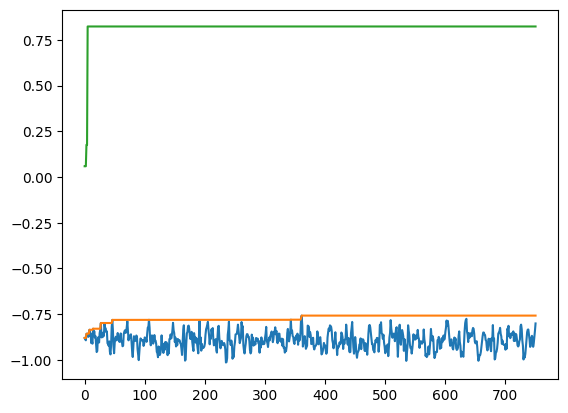

C:\Users\Milos\PycharmProjects\MyDiploma\Dimploma\tr_util.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_graph = torch.load(testesing_agent + '/graph.pt')


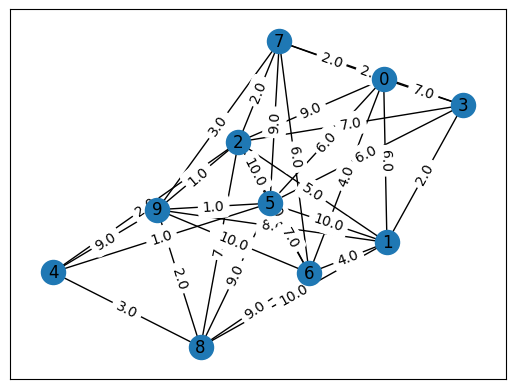

Loading model from results/min_tree_ppo/node/250307_14#n10_e33_g20_without//models/iter_999_last.pt


C:\Users\Milos\PycharmProjects\MyDiploma\Dimploma\ppo_parallel_custom.py:376: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(path))


In [22]:
loaded_graph, test_env, agent_test = tr_util.load_agent_for_testing(agent.path, iteration_amount, graph_provider, GCN(node_amount, node_features, cat_in_net, conv_layers, conv_p_layers, linear_layers, remove_index=remove_index), device)

In [23]:
# Testing
test_amount = 100
objs_test = np.zeros(test_amount, dtype=np.float32)
rews_test = np.zeros(test_amount, dtype=np.float32)
actions_test = np.zeros((test_amount, node_amount * 2), dtype=np.int16)

objs_test_r = np.zeros(test_amount, dtype=np.float32)
rews_test_r = np.zeros(test_amount, dtype=np.float32)
actions_test_r = np.zeros((test_amount, node_amount * 2), dtype=np.int16)

for i in range(test_amount):
    obj, sel, rew, acts = agent_test.test(test_env)
    objs_test[i] = obj
    rews_test[i] = rew[-1]
    actions_test[i, :len(acts)] = acts
    
    obj_r, sel_r, rew_r, acts_r  = test_random(test_env)
    objs_test_r[i] = obj_r
    rews_test_r[i] = rew_r[-1]
    actions_test_r[i, :len(acts_r)] = acts_r
    # print(sel)

print("Objs")
print(f'Mean: {objs_test.mean():.2f}')
print(f'Min: {objs_test.min()}')
print(f'Max: {objs_test.max()}')
print("Random")
print(f'Mean: {objs_test_r.mean():.2f}')
print(f'Min: {objs_test_r.min()}')
print(f'Max: {objs_test_r.max()}')

Objs
Mean: 49.23
Min: 27.0
Max: 70.0
Random
Mean: 49.49
Min: 23.0
Max: 65.0


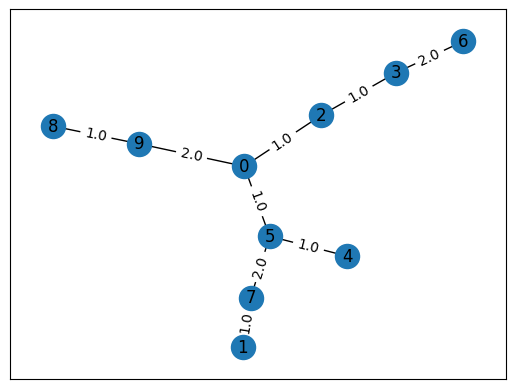

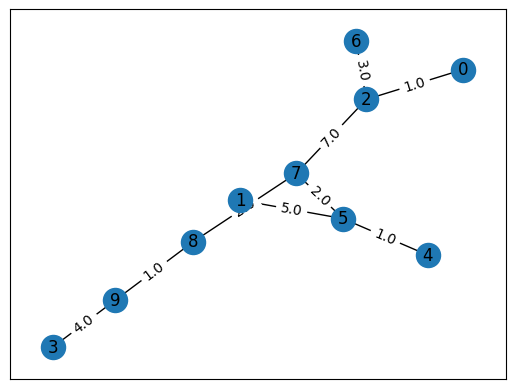

(tensor([0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.]),
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.16666666666666652],
 [2, 6, 5, 7, 5, 4, 7, 8, 7, 2, 9, 8, 2, 0, 5, 1, 9, 3])

In [26]:
_ ,a, b, c = agent_test.test(test_env)
util.show_data(test_env.min_tree)
test_env.show_selected_tree()

# mask = torch.argwhere(graph_test.edge_attr[:, 1] == 1)[:, 0]
# sel_graph = Data(x=graph_test.x, edge_index=graph_test.edge_index[:, mask], edge_weight=graph_test.edge_weight[mask])
# sel_graph_g = util.my_to_networkx(sel_graph)
# util.show_data(sel_graph)
a,b,c

In [27]:
util.get_node_sums(test_env.graph)

tensor([[7.0000, 5.0000, 2.0000, 9.0000, 0.0000, 3.0000, 8.0000, 1.0000, 4.0000,
         6.0000],
        [1.9000, 3.5000, 3.6000, 3.6000, 3.8000, 3.8000, 3.9000, 4.0000, 4.4000,
         4.5000]])

In [28]:
util.get_out_edges(test_env.graph)

tensor([[7., 1., 3., 4., 8., 9., 0., 2., 5., 6.],
        [5., 7., 7., 7., 7., 7., 8., 8., 8., 8.]])